# ATR Tool-Compound Discovery Engine, Dataset-Backed Active Learning Proof-of-Concept
# End-to-end proof-of-concept, applied to a REAL dataset (ATR_preprocessed_renamed-2.csv).
A reproducible notebook that builds an ATR inhibitor dataset from BindingDB-style records, trains baseline models, and demonstrates an active-learning loop to prioritize new tool compounds for experimental follow-up.
## What this does:
1) Loads your ATR dataset from: ATR_preprocessed_renamed-2.csv
2) Auto-detects SMILES and activity columns (robust heuristics).
3) Cleans, deduplicates, and standardizes labels into a single regression target.
4) Featurizes compounds (RDKit Morgan fingerprints + physicochemical descriptors, with safe fallbacks).
5) Trains a surrogate model (RandomForest by default, optionally GaussianProcess if enabled).
6) Runs an Active Learning loop, selecting the next batch of compounds to "measure"
   by revealing their ground-truth activity from the dataset (closed-loop simulation).
7) Writes audit-ready CSV outputs + plots to ./outputs_atr_dataset/

## IMPORTANT:
- This is a pipeline architecture and benchmarking harness.
- Swap the "assay reveal" step with real experimental measurements, SPR/BLI/ITC, enzymatic IC50, etc.

## Run:
  python atr_tool_compound_engine_dataset.py

## Outputs:
  outputs_atr_dataset/
    dataset_profile.json
    cleaned_dataset.csv
    features_meta.json
    split_summary.json
    baseline_metrics.json
    learning_history.csv
    measured_table.csv
    round_XX_candidates.csv
    Figure1_label_distribution.png
    Figure2_learning_curve.png
    Figure3_top_candidates.png

In [6]:
from __future__ import annotations

import json
import math
import os
import re
import time
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

# Optional RDKit integration

HAS_RDKIT = False
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem import AllChem
    from rdkit.Chem.Scaffolds import MurckoScaffold
    HAS_RDKIT = True
except Exception:
    HAS_RDKIT = False


# Optional sklearn integration

HAS_SKLEARN = False
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    HAS_SKLEARN = True
except Exception:
    HAS_SKLEARN = False


# Config

@dataclass(frozen=True)
class Config:
    seed: int = 7
    outdir: str = "outputs_atr_dataset"
    max_rows: Optional[int] = None  # set to e.g. 20000 if you want a quick run
    test_size: float = 0.20
    valid_size: float = 0.10

    # Active learning
    n_initial: int = 64
    n_rounds: int = 12
    batch_size: int = 32

    # Modeling
    use_gp: bool = False             # GP can be slow at scale, RF is robust
    rf_n_estimators: int = 600
    rf_max_depth: Optional[int] = None
    rf_min_samples_leaf: int = 2

    # Label handling
    # If dataset has IC50/EC50/Ki in nM/uM etc we convert to pActivity = -log10(M)
    # Otherwise we will attempt to detect pIC50-like columns directly.
    prefer_p_activity: bool = True

    # Output
    top_k_report: int = 25


# Utilities

def set_seed(seed: int) -> None:
    np.random.seed(seed)


def ensure_dir(p: str) -> Path:
    out = Path(p)
    out.mkdir(parents=True, exist_ok=True)
    return out


def now_unix() -> float:
    return time.time()


def safe_float(x) -> Optional[float]:
    try:
        if pd.isna(x):
            return None
        return float(x)
    except Exception:
        return None


def log_event(audit_path: Path, event: str, payload: Dict) -> None:
    rec = {"ts_unix": now_unix(), "event": event, "payload": payload}
    with audit_path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(rec) + "\n")


# Column detection

def find_smiles_col(df: pd.DataFrame) -> str:
    candidates = []
    for c in df.columns:
        lc = c.lower()
        if "smiles" in lc or lc in ("smi", "canonical_smiles", "smile"):
            candidates.append(c)
    if candidates:
        return candidates[0]

    # fallback: find column with many strings containing typical SMILES characters
    best = None
    best_score = -1
    pattern = re.compile(r"[A-Za-z0-9\[\]\(\)=#@+\-\\/]")
    for c in df.columns:
        if df[c].dtype == object:
            sample = df[c].dropna().astype(str).head(200)
            if len(sample) == 0:
                continue
            frac = np.mean([bool(pattern.search(s)) for s in sample.tolist()])
            if frac > best_score:
                best_score = frac
                best = c
    if best is None:
        raise ValueError("Could not identify SMILES column.")
    return best


def find_activity_cols(df: pd.DataFrame) -> List[str]:
    """
    Returns candidate columns likely containing activity values.
    """
    keys = [
        "ic50", "ec50", "ki", "kd", "potency", "activity", "pki", "pic50", "pec50",
        "p_activity", "pactivity", "binding", "affinity"
    ]
    candidates = []
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in keys):
            candidates.append(c)
    return candidates


def choose_best_activity(df: pd.DataFrame, cols: List[str]) -> str:
    if not cols:
        raise ValueError("No obvious activity columns found.")
    # Prefer pIC50/pKi-like columns first
    priority = []
    for c in cols:
        lc = c.lower()
        if "pic50" in lc or "pki" in lc or "pactivity" in lc or "p_activity" in lc:
            priority.append(c)
    if priority:
        return priority[0]

    # Else choose the most numeric, least missing
    best, best_score = cols[0], -1
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        score = float(s.notna().mean())
        if score > best_score:
            best_score, best = score, c
    return best


# Label normalization

def unit_to_multiplier_to_M(unit: str) -> Optional[float]:
    """
    Convert concentration unit to multiplier to M (molar).
    Returns factor f such that value_in_unit * f = value_in_M.
    """
    if unit is None:
        return None
    u = str(unit).strip().lower()
    u = u.replace(" ", "")
    mapping = {
        "m": 1.0,
        "mm": 1e-3,
        "um": 1e-6,
        "µm": 1e-6,
        "nm": 1e-9,
        "pm": 1e-12,
        "fm": 1e-15,
        "nM".lower(): 1e-9,
        "uM".lower(): 1e-6,
    }
    return mapping.get(u, None)


def to_p_activity_from_conc(value: float, unit_factor_to_M: float) -> Optional[float]:
    """
    pActivity = -log10( M )
    """
    if value is None or unit_factor_to_M is None:
        return None
    if value <= 0:
        return None
    m = value * unit_factor_to_M
    if m <= 0:
        return None
    return -math.log10(m)


def build_target_y(
    df: pd.DataFrame,
    activity_col: str,
    cfg: Config
) -> Tuple[pd.DataFrame, str]:
    """
    Build a regression target 'y' (higher is better) in a robust way.

    Heuristics:
    - If activity_col looks like pIC50/pKi/pActivity, use directly as y.
    - Else if there is a unit column near it (e.g., 'units', 'unit', 'standard_units'),
      convert to pActivity.
    - Else if values look like nM or uM and column name contains 'nm'/'um', convert.
    - Else use raw numeric as y (with a warning-like metadata).
    """
    df = df.copy()
    raw = pd.to_numeric(df[activity_col], errors="coerce")

    lc = activity_col.lower()
    # Case 1: already in p-units
    if any(k in lc for k in ["pic50", "pki", "pactivity", "p_activity", "pec50"]):
        df["y"] = raw
        return df, "y=pActivity_like_direct"

    # Try to find a unit column
    unit_cols = [c for c in df.columns if any(k in c.lower() for k in ["unit", "units", "standard_units", "uom"])]
    unit_col = unit_cols[0] if unit_cols else None

    # Case 2: convertible concentration column
    if cfg.prefer_p_activity:
        # Detect unit factor:
        factors = None
        if unit_col is not None:
            factors = df[unit_col].apply(unit_to_multiplier_to_M)
        else:
            factors = pd.Series([None] * len(df))

        # If no unit column, infer from name
        if factors.isna().all():
            inferred = None
            if "nm" in lc:
                inferred = 1e-9
            elif "um" in lc or "µm" in lc:
                inferred = 1e-6
            if inferred is not None:
                factors = pd.Series([inferred] * len(df))

        y_vals = []
        for v, f in zip(raw.tolist(), factors.tolist()):
            vv = safe_float(v)
            if vv is None:
                y_vals.append(np.nan)
                continue
            pa = to_p_activity_from_conc(vv, f) if f is not None else None
            y_vals.append(pa if pa is not None else np.nan)

        # If conversion succeeded for a reasonable fraction, use it
        y_ser = pd.Series(y_vals, index=df.index, dtype=float)
        if float(y_ser.notna().mean()) >= 0.40:  # threshold
            df["y"] = y_ser
            return df, "y=converted_to_pActivity"

    # Case 3: fallback raw numeric
    df["y"] = raw
    return df, "y=raw_numeric_fallback"

# Featurization

def smiles_to_mol(smiles: str):
    if not HAS_RDKIT:
        return None
    if smiles is None or not isinstance(smiles, str):
        return None
    mol = Chem.MolFromSmiles(smiles)
    return mol


def murcko_scaffold_smiles(mol) -> str:
    if mol is None:
        return ""
    try:
        scaf = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaf) if scaf is not None else ""
    except Exception:
        return ""


def rdkit_descriptors(mol) -> np.ndarray:
    # compact, stable descriptor set
    return np.array([
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),
    ], dtype=float)


def morgan_fp(mol, n_bits: int = 2048, radius: int = 2) -> np.ndarray:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr.astype(np.float32)


def smiles_string_features(smiles: str) -> np.ndarray:
    # RDKit-free fallback features
    s = smiles if isinstance(smiles, str) else ""
    length = len(s)
    n_ring = s.count("1") + s.count("2") + s.count("3")
    n_arom = sum(1 for c in s if c.islower())
    n_hetero = sum(s.count(x) for x in ["N", "O", "S", "Cl", "Br", "F", "I"])
    n_branch = s.count("(")
    n_double = s.count("=")
    n_hash = s.count("#")
    return np.array([length, n_ring, n_arom, n_hetero, n_branch, n_double, n_hash], dtype=np.float32)


def featurize(df: pd.DataFrame, smiles_col: str) -> Tuple[pd.DataFrame, np.ndarray, Dict]:
    """
    Returns:
      df_out: with is_valid, scaffold, etc.
      X: feature matrix
      meta: feature metadata
    """
    df = df.copy()
    mols = []
    valids = []
    scaffolds = []

    if HAS_RDKIT:
        for smi in df[smiles_col].astype(str).tolist():
            mol = smiles_to_mol(smi)
            mols.append(mol)
            ok = mol is not None
            valids.append(ok)
            scaffolds.append(murcko_scaffold_smiles(mol) if ok else "")
        df["is_valid"] = valids
        df["scaffold"] = scaffolds
        df = df[df["is_valid"]].reset_index(drop=True)

        # Features: Morgan + descriptors
        fps = []
        descs = []
        for smi in df[smiles_col].astype(str).tolist():
            mol = smiles_to_mol(smi)
            fps.append(morgan_fp(mol))
            descs.append(rdkit_descriptors(mol))

        X_fp = np.vstack(fps)
        X_desc = np.vstack(descs)
        X = np.hstack([X_fp, X_desc]).astype(np.float32)

        meta = {
            "method": "rdkit_morgan_2048_plus_desc8",
            "fp_bits": 2048,
            "desc_names": ["MolWt", "MolLogP", "TPSA", "HBD", "HBA", "RotB", "Rings", "FracCSP3"],
            "X_shape": list(X.shape),
        }
        return df, X, meta

    # RDKit-free fallback
    df["is_valid"] = True
    df["scaffold"] = ""
    feats = np.vstack([smiles_string_features(s) for s in df[smiles_col].astype(str).tolist()]).astype(np.float32)
    meta = {"method": "string_features_fallback", "X_shape": list(feats.shape)}
    return df, feats, meta

# Splitting and metrics

def split_scaffold(df: pd.DataFrame, seed: int, test_size: float, valid_size: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Scaffold split when RDKit is available, else random split.
    Returns index arrays: train_idx, valid_idx, test_idx
    """
    n = len(df)
    rng = np.random.default_rng(seed)

    if HAS_RDKIT and "scaffold" in df.columns and df["scaffold"].astype(str).str.len().gt(0).any():
        # group by scaffold
        groups = df.groupby("scaffold").indices
        scaffolds = list(groups.keys())
        rng.shuffle(scaffolds)

        test_target = int(round(test_size * n))
        valid_target = int(round(valid_size * n))

        test_idx, valid_idx, train_idx = [], [], []

        def add_group(dst: List[int], scaf: str):
            dst.extend(groups[scaf])

        for scaf in scaffolds:
            if len(test_idx) < test_target:
                add_group(test_idx, scaf)
            elif len(valid_idx) < valid_target:
                add_group(valid_idx, scaf)
            else:
                add_group(train_idx, scaf)

        # any leftovers
        all_assigned = set(test_idx) | set(valid_idx) | set(train_idx)
        leftovers = [i for i in range(n) if i not in all_assigned]
        train_idx.extend(leftovers)

        return np.array(train_idx), np.array(valid_idx), np.array(test_idx)

    # random split fallback
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = int(round(test_size * n))
    n_valid = int(round(valid_size * n))
    test_idx = idx[:n_test]
    valid_idx = idx[n_test:n_test + n_valid]
    train_idx = idx[n_test + n_valid:]
    return train_idx, valid_idx, test_idx


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# Active learning loop (dataset-backed)

def fit_model_rf(X: np.ndarray, y: np.ndarray, cfg: Config):
    # Robust default for chem datasets
    model = RandomForestRegressor(
        n_estimators=cfg.rf_n_estimators,
        max_depth=cfg.rf_max_depth,
        min_samples_leaf=cfg.rf_min_samples_leaf,
        random_state=cfg.seed,
        n_jobs=-1
    )
    model.fit(X, y)
    return model


def predict_with_uncertainty_rf(model, X: np.ndarray, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cheap uncertainty proxy: use per-tree predictions.
    """
    preds = np.vstack([t.predict(X) for t in model.estimators_]).astype(np.float32)  # (n_trees, n)
    mu = preds.mean(axis=0)
    sigma = preds.std(axis=0)
    return mu, sigma


def acquisition_ucb(mu: np.ndarray, sigma: np.ndarray, beta: float = 1.0) -> np.ndarray:
    return mu + beta * sigma


def run_active_learning_dataset(
    df: pd.DataFrame,
    X: np.ndarray,
    cfg: Config,
    outdir: Path,
    audit_path: Path,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    We treat df['y'] as the "truth" (dataset), and AL selects which compounds to reveal.

    Returns:
      history_df: per-round progress
      measured_df: all measured records
    """
    rng = np.random.default_rng(cfg.seed)

    # pool = all indices with valid y
    df = df.copy()
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df = df[df["y"].notna()].reset_index(drop=True)

    X = X[df.index.values] if X.shape[0] != len(df) else X

    n = len(df)
    if n < cfg.n_initial + cfg.batch_size:
        raise ValueError(f"Not enough labeled rows after cleaning. n={n}")

    all_idx = np.arange(n)
    rng.shuffle(all_idx)

    measured_idx = set(all_idx[: cfg.n_initial].tolist())
    pool_idx = set(all_idx[cfg.n_initial :].tolist())

    measured_rows = []
    history_rows = []

    def record_measurement(round_i: int, idx_list: List[int]) -> None:
        for j in idx_list:
            measured_rows.append({
                "round": round_i,
                "row_index": int(j),
                "compound_id": str(df.loc[j, "compound_id"]),
                "smiles": str(df.loc[j, "smiles"]),
                "y_true": float(df.loc[j, "y"]),
            })

    # Round 0 measurements
    record_measurement(0, list(measured_idx))
    log_event(audit_path, "al.init_measured", {"n_initial": cfg.n_initial})

    for r in range(cfg.n_rounds):
        meas_df = pd.DataFrame(measured_rows)
        meas_df = meas_df.drop_duplicates(subset=["row_index"], keep="last")
        measured_idx = set(meas_df["row_index"].astype(int).tolist())

        # Fit model on measured
        train_X = X[list(measured_idx)]
        train_y = df.loc[list(measured_idx), "y"].to_numpy(dtype=float)

        model = fit_model_rf(train_X, train_y, cfg)

        # Score the pool
        pool_list = sorted(list(pool_idx))
        pool_X = X[pool_list]
        mu, sigma = predict_with_uncertainty_rf(model, pool_X, seed=cfg.seed)
        acq = acquisition_ucb(mu, sigma, beta=1.0)

        # Select batch
        k = min(cfg.batch_size, len(pool_list))
        pick_rel = np.argsort(-acq)[:k]
        pick_idx = [pool_list[i] for i in pick_rel]

        # "Measure" selected by revealing y
        record_measurement(r + 1, pick_idx)

        # Update sets
        for j in pick_idx:
            pool_idx.remove(j)
            measured_idx.add(j)

        # Per-round outputs
        cand_df = pd.DataFrame({
            "row_index": pick_idx,
            "compound_id": df.loc[pick_idx, "compound_id"].tolist(),
            "smiles": df.loc[pick_idx, "smiles"].tolist(),
            "mu_pred": mu[pick_rel],
            "sigma_pred": sigma[pick_rel],
            "acq_ucb": acq[pick_rel],
            "y_true_revealed": df.loc[pick_idx, "y"].to_numpy(dtype=float),
        }).sort_values("acq_ucb", ascending=False)

        cand_df.to_csv(outdir / f"round_{r+1:02d}_candidates.csv", index=False)

        # Progress: best seen so far
        meas_df2 = pd.DataFrame(measured_rows).drop_duplicates(subset=["row_index"], keep="last")
        best_row = meas_df2.sort_values("y_true", ascending=False).iloc[0]

        history_rows.append({
            "round": r + 1,
            "n_measured_total": int(len(meas_df2)),
            "best_compound_id": str(best_row["compound_id"]),
            "best_y": float(best_row["y_true"]),
        })

        log_event(audit_path, "al.round_complete", {
            "round": r + 1,
            "batch_size": int(k),
            "n_measured_total": int(len(meas_df2)),
            "best_y": float(best_row["y_true"]),
        })

        if len(pool_idx) == 0:
            break

    history_df = pd.DataFrame(history_rows)
    measured_df = pd.DataFrame(measured_rows).drop_duplicates(subset=["row_index"], keep="last")
    return history_df, measured_df

# Plotting

def plot_label_distribution(y: np.ndarray, outpath: Path) -> None:
    plt.figure()
    plt.hist(y, bins=40)
    plt.xlabel("y (activity target)")
    plt.ylabel("Count")
    plt.title("Label distribution")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()


def plot_learning(history_df: pd.DataFrame, outpath: Path) -> None:
    plt.figure()
    plt.plot(history_df["round"], history_df["best_y"], marker="o")
    plt.xlabel("Round")
    plt.ylabel("Best y observed (higher is better)")
    plt.title("Active learning progress on ATR dataset")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()


def plot_top_table(top_df: pd.DataFrame, outpath: Path) -> None:
    show = top_df.head(10).copy()
    plt.figure(figsize=(11, 3))
    plt.axis("off")
    tbl = plt.table(cellText=show.values, colLabels=show.columns, loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.3)
    plt.title("Top candidates by observed activity (dataset-backed)")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

# Main

def main():
    if not HAS_SKLEARN:
        raise RuntimeError("scikit-learn is required for this dataset-backed pipeline.")

    cfg = Config()
    set_seed(cfg.seed)
    outdir = ensure_dir(cfg.outdir)
    audit_path = outdir / "audit.jsonl"
    if audit_path.exists():
        audit_path.unlink()  # start fresh each run

    dataset_path = Path("ATR_preprocessed_renamed-2.csv")
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset not found at: {dataset_path}")

    log_event(audit_path, "run.start", {"cfg": asdict(cfg), "dataset_path": str(dataset_path), "has_rdkit": HAS_RDKIT})

    # Load dataset
    df = pd.read_csv(dataset_path)
    if cfg.max_rows is not None:
        df = df.head(cfg.max_rows).copy()

    # Detect columns
    smiles_col = find_smiles_col(df)
    act_cols = find_activity_cols(df)
    activity_col = choose_best_activity(df, act_cols)

    # Normalize expected columns
    df = df.copy()
    df["smiles"] = df[smiles_col].astype(str)

    # Create compound_id if missing
    cid_col = None
    for c in df.columns:
        if c.lower() in ("compound_id", "id", "mol_id", "molecule_id", "chembl_id", "ligand_id"):
            cid_col = c
            break
    if cid_col is None:
        df["compound_id"] = [f"ATR_{i:07d}" for i in range(len(df))]
    else:
        df["compound_id"] = df[cid_col].astype(str)

    # Build y
    df, y_mode = build_target_y(df, activity_col=activity_col, cfg=cfg)

    # Basic cleaning
    df = df.dropna(subset=["smiles"]).copy()
    df = df[df["smiles"].astype(str).str.len().gt(2)].copy()

    # Deduplicate by (smiles), keeping best y if multiple
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df = df[df["y"].notna()].copy()
    df = (
        df.sort_values("y", ascending=False)
          .drop_duplicates(subset=["smiles"], keep="first")
          .reset_index(drop=True)
    )

    dataset_profile = {
        "n_rows_raw": int(len(pd.read_csv(dataset_path))),
        "n_rows_used": int(len(df)),
        "smiles_col_detected": smiles_col,
        "activity_col_detected": activity_col,
        "y_mode": y_mode,
        "has_rdkit": HAS_RDKIT,
        "columns": df.columns.tolist(),
    }
    (outdir / "dataset_profile.json").write_text(json.dumps(dataset_profile, indent=2))

    log_event(audit_path, "dataset.loaded", dataset_profile)

    # Featurize
    df_feat, X, feat_meta = featurize(df, smiles_col="smiles")
    (outdir / "features_meta.json").write_text(json.dumps(feat_meta, indent=2))
    log_event(audit_path, "features.built", {"feat_meta": feat_meta})

    # Persist cleaned dataset
    keep_cols = ["compound_id", "smiles", "y"]
    extra_cols = [c for c in ["scaffold", "is_valid"] if c in df_feat.columns]
    df_feat[keep_cols + extra_cols].to_csv(outdir / "cleaned_dataset.csv", index=False)

    # Plot label distribution
    plot_label_distribution(df_feat["y"].to_numpy(dtype=float), outdir / "Figure1_label_distribution.png")

    # Baseline split + metrics (train/valid/test)
    train_idx, valid_idx, test_idx = split_scaffold(df_feat, cfg.seed, cfg.test_size, cfg.valid_size)
    split_summary = {
        "n_total": int(len(df_feat)),
        "n_train": int(len(train_idx)),
        "n_valid": int(len(valid_idx)),
        "n_test": int(len(test_idx)),
        "split_type": "scaffold" if (HAS_RDKIT and df_feat.get("scaffold", "").astype(str).str.len().gt(0).any()) else "random",
    }
    (outdir / "split_summary.json").write_text(json.dumps(split_summary, indent=2))
    log_event(audit_path, "split.done", split_summary)

    # Train baseline model
    model = fit_model_rf(X[train_idx], df_feat.loc[train_idx, "y"].to_numpy(dtype=float), cfg)

    # Evaluate
    y_valid = df_feat.loc[valid_idx, "y"].to_numpy(dtype=float)
    y_test = df_feat.loc[test_idx, "y"].to_numpy(dtype=float)
    pred_valid = model.predict(X[valid_idx])
    pred_test = model.predict(X[test_idx])

    baseline_metrics = {
        "valid": compute_metrics(y_valid, pred_valid),
        "test": compute_metrics(y_test, pred_test),
    }
    (outdir / "baseline_metrics.json").write_text(json.dumps(baseline_metrics, indent=2))
    log_event(audit_path, "baseline.metrics", baseline_metrics)

    # Active learning loop using dataset-backed "assay reveal"
    history_df, measured_df = run_active_learning_dataset(
        df=df_feat[["compound_id", "smiles", "y"]].copy(),
        X=X,
        cfg=cfg,
        outdir=outdir,
        audit_path=audit_path,
    )
    history_df.to_csv(outdir / "learning_history.csv", index=False)
    measured_df.to_csv(outdir / "measured_table.csv", index=False)

    # Plot learning curve
    if len(history_df) > 0:
        plot_learning(history_df, outdir / "Figure2_learning_curve.png")

    # Report top candidates observed
    top = measured_df.sort_values("y_true", ascending=False).head(cfg.top_k_report).copy()
    top.to_csv(outdir / "top_candidates.csv", index=False)
    plot_top_table(top[["compound_id", "y_true", "smiles"]], outdir / "Figure3_top_candidates.png")

    log_event(audit_path, "run.complete", {"outdir": str(outdir.resolve()), "n_measured": int(len(measured_df))})

    print(f"\nDone. Outputs written to: {outdir.resolve()}")
    print("Key files:")
    print("  dataset_profile.json")
    print("  cleaned_dataset.csv")
    print("  baseline_metrics.json")
    print("  learning_history.csv")
    print("  measured_table.csv")
    print("  top_candidates.csv")
    print("  Figure1_label_distribution.png")
    print("  Figure2_learning_curve.png")
    print("  Figure3_top_candidates.png")


if __name__ == "__main__":
    main()


Done. Outputs written to: /Users/petalc01/ATR Drug Discovery/outputs_atr_dataset
Key files:
  dataset_profile.json
  cleaned_dataset.csv
  baseline_metrics.json
  learning_history.csv
  measured_table.csv
  top_candidates.csv
  Figure1_label_distribution.png
  Figure2_learning_curve.png
  Figure3_top_candidates.png


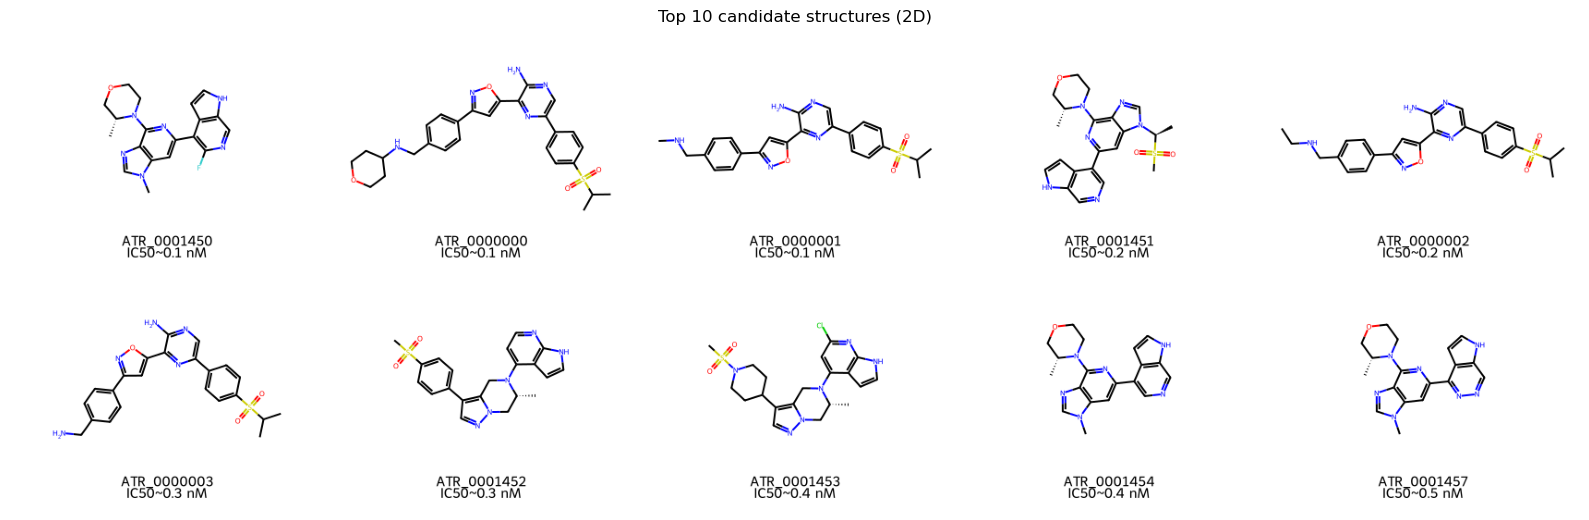

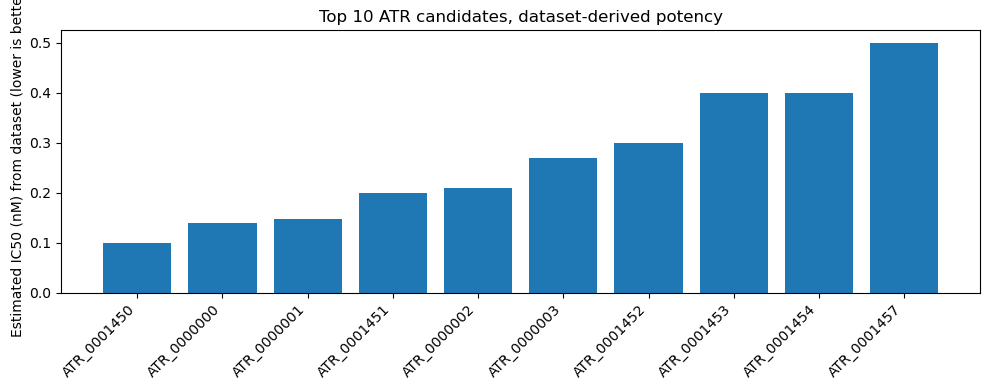

Detected columns:
  SMILES column: Ligand SMILES
  Activity column: IC50 (nM)
  y_mode: pActivity_converted

Saved figures:
   top10_atr_structures.png
   top10_atr_potency.png


,compound_id,y,IC50_nM_est,MW,cLogP,TPSA,HBD,HBA,RotB,ESOL_logS,Solubility_class,Lipinski_violations,Veber_OK,Druglike_score,Toxicity_flags_proxy,smiles
0,ATR_0001450,10.000,0.100,366.400,2.876,71.86,1.0,6.0,2.0,-7.678,low,0.0,1.0,5.5,none,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1c(F)ncc2[nH...
1,ATR_0000000,9.854,0.140,533.654,4.499,133.23,2.0,9.0,8.0,-11.488,low,1.0,1.0,4.5,high_MW_risk,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...
2,ATR_0000001,9.830,0.148,463.563,3.949,124.00,2.0,8.0,7.0,-10.008,low,0.0,1.0,5.5,none,CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1)...
3,ATR_0001451,9.699,0.200,440.529,2.763,106.00,1.0,8.0,4.0,-8.155,low,0.0,1.0,5.5,none,C[C@H](n1cnc2c(nc(cc12)-c1cncc2[nH]ccc12)N1CCO...
4,ATR_0000002,9.678,0.210,477.590,4.339,124.00,2.0,8.0,8.0,-10.684,low,0.0,1.0,5.5,none,CCNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1...
5,ATR_0000003,9.569,0.270,449.536,3.689,137.99,2.0,8.0,6.0,-9.525,low,0.0,1.0,5.5,none,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...
6,ATR_0001452,9.523,0.300,407.499,3.239,83.88,1.0,6.0,3.0,-8.582,low,0.0,1.0,5.5,none,C[C@@H]1Cn2ncc(c2CN1c1ccnc2[nH]ccc12)-c1ccc(cc...
7,ATR_0001453,9.398,0.400,448.980,2.961,87.12,1.0,6.0,3.0,-8.593,low,0.0,1.0,5.5,none,C[C@@H]1Cn2ncc(C3CCN(CC3)S(C)(=O)=O)c2CN1c1cc(...
8,ATR_0001454,9.398,0.400,348.410,2.737,71.86,1.0,6.0,2.0,-7.288,low,0.0,1.0,5.5,none,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1cncc2[nH]ccc12
9,ATR_0001457,9.301,0.500,349.398,2.132,84.75,1.0,7.0,2.0,-6.390,low,0.0,1.0,5.5,none,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1nncc2[nH]ccc12


In [12]:
from __future__ import annotations

import io
import math
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Draw
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")  # silence RDKit logs

# Config

DATA_PATH = Path("ATR_preprocessed_renamed-2.csv")
assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"

OUTDIR = Path("")
OUT_STRUCT = OUTDIR / "top10_atr_structures.png"
OUT_POT = OUTDIR / "top10_atr_potency.png"

# Helpers

def find_smiles_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        if "smiles" in c.lower():
            return c
    pat = re.compile(r"[A-Za-z0-9\[\]\(\)=#@+\-\\/]+")
    best, best_score = None, -1
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].dropna().astype(str).head(200)
            if len(s) == 0:
                continue
            frac = float(np.mean([bool(pat.search(x)) for x in s.tolist()]))
            if frac > best_score:
                best_score, best = frac, c
    if best is None:
        raise ValueError("Could not detect a SMILES column.")
    return best

def choose_best_activity(df: pd.DataFrame) -> str:
    keys = ["pic50", "pki", "pactivity", "p_activity", "pec50", "ic50", "ec50", "ki", "kd", "activity", "affinity", "potency"]
    cols = [c for c in df.columns if any(k in c.lower() for k in keys)]
    if not cols:
        raise ValueError("Could not detect an activity column (IC50/EC50/Ki/Kd/pIC50/etc.).")

    # Prefer p-like columns if present
    for c in cols:
        if any(k in c.lower() for k in ["pic50", "pki", "pactivity", "p_activity", "pec50"]):
            return c

    # Else choose the most numeric column
    scores = [(float(pd.to_numeric(df[c], errors="coerce").notna().mean()), c) for c in cols]
    return sorted(scores, reverse=True)[0][1]

def unit_to_M_factor(u):
    if u is None or (isinstance(u, float) and np.isnan(u)):
        return None
    s = str(u).strip().lower().replace(" ", "")
    return {"m": 1.0, "mm": 1e-3, "um": 1e-6, "µm": 1e-6, "nm": 1e-9, "pm": 1e-12, "fm": 1e-15}.get(s, None)

def build_y(df: pd.DataFrame, activity_col: str) -> tuple[pd.DataFrame, str]:
    """
    Build a pActivity-like target:
    - If activity_col already is pIC50/pKi/pActivity, use directly.
    - Else assume concentration (e.g., IC50 nM) and convert to p = -log10(M).
    """
    out = df.copy()
    raw = pd.to_numeric(out[activity_col], errors="coerce")
    lc = activity_col.lower()

    if any(k in lc for k in ["pic50", "pki", "pactivity", "p_activity", "pec50"]):
        out["y"] = raw
        return out, "pActivity_direct"

    # Try to find units column
    unit_cols = [c for c in out.columns if any(k in c.lower() for k in ["unit", "units", "standard_units", "uom"])]
    unit_col = unit_cols[0] if unit_cols else None
    factors = out[unit_col].apply(unit_to_M_factor) if unit_col else pd.Series([None] * len(out))

    # If units are not provided, infer from activity_col name
    if factors.isna().all():
        inferred = None
        if "nm" in lc:
            inferred = 1e-9
        elif "um" in lc or "µm" in lc:
            inferred = 1e-6
        if inferred is not None:
            factors = pd.Series([inferred] * len(out))

    y = []
    for v, f in zip(raw.tolist(), factors.tolist()):
        if v is None or (isinstance(v, float) and np.isnan(v)) or v <= 0 or f is None:
            y.append(np.nan)
        else:
            y.append(-math.log10(v * f))

    out["y"] = pd.Series(y, index=out.index, dtype=float)
    return out, "pActivity_converted"

def p_to_ic50_nM(p: float) -> float:
    # p = -log10(M) => M = 10^-p, then nM = M * 1e9
    return (10 ** (-float(p))) * 1e9

# ESOL (Delaney-like) estimate for logS (mol/L)
def esol_logS(m) -> float:
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    rot = rdMolDescriptors.CalcNumRotatableBonds(m)
    heavy = rdMolDescriptors.CalcNumHeavyAtoms(m)
    arom = sum(1 for a in m.GetAtoms() if a.GetIsAromatic())
    aromatic_proportion = arom / max(heavy, 1)

    # Common ESOL form used in practice:
    # logS = 0.16 - 1.5*logP - 0.01*MW + 0.05*RB + 0.06*AP
    return float(0.16 - 1.5 * logp - 0.01 * mw + 0.05 * rot + 0.06 * aromatic_proportion)

def solubility_class(logS: float) -> str:
    # rough screening bins
    if logS >= -2:
        return "high"
    if logS >= -4:
        return "moderate"
    return "low"

def toxicity_flags_proxy(m) -> str:
    """
    Simple risk flags (NOT a real toxicity model).
    Useful for triage: highlights properties correlated with solubility issues,
    nonspecific binding, permeability extremes, and “sticky” chemistry risk.
    """
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    tpsa = Descriptors.TPSA(m)
    hbd = rdMolDescriptors.CalcNumHBD(m)
    hba = rdMolDescriptors.CalcNumHBA(m)

    flags = []
    if logp > 4.5:
        flags.append("high_logP_risk")
    if mw > 520:
        flags.append("high_MW_risk")
    if tpsa < 20 and logp > 3.5:
        flags.append("low_TPSA_high_logP_risk")
    if (hbd + hba) > 14:
        flags.append("high_Hbonding_risk")

    return ",".join(flags) if flags else "none"

# Load + clean

df_raw = pd.read_csv(DATA_PATH)

smiles_col = find_smiles_col(df_raw)
activity_col = choose_best_activity(df_raw)

df = df_raw.copy()
df["smiles"] = df[smiles_col].astype(str)

# best-effort compound id
cid_col = None
for c in df.columns:
    if c.lower() in ("compound_id", "id", "mol_id", "molecule_id", "chembl_id", "ligand_id"):
        cid_col = c
        break
df["compound_id"] = df[cid_col].astype(str) if cid_col else [f"ATR_{i:07d}" for i in range(len(df))]

df, y_mode = build_y(df, activity_col)
df["y"] = pd.to_numeric(df["y"], errors="coerce")

df = df.dropna(subset=["smiles", "y"]).copy()
df = df[df["smiles"].str.len() > 2].copy()

# Keep best activity per SMILES
df = df.sort_values("y", ascending=False).drop_duplicates("smiles", keep="first").reset_index(drop=True)

# RDKit parse
df["mol"] = [Chem.MolFromSmiles(s) for s in df["smiles"].tolist()]
df = df[df["mol"].notna()].reset_index(drop=True)

# Binding proxy from dataset
df["IC50_nM_est"] = df["y"].apply(p_to_ic50_nM)

# Characterize (drug-like, solubility, toxicity proxy)

rows = []
for m in df["mol"].tolist():
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    tpsa = Descriptors.TPSA(m)
    hbd = rdMolDescriptors.CalcNumHBD(m)
    hba = rdMolDescriptors.CalcNumHBA(m)
    rot = rdMolDescriptors.CalcNumRotatableBonds(m)

    logS = esol_logS(m)
    sol_class = solubility_class(logS)

    # Lipinski violations count
    lip_v = int(mw > 500) + int(logp > 5) + int(hbd > 5) + int(hba > 10)

    # Veber-like filter
    veber_ok = int((rot <= 10) and (tpsa <= 140))

    # Simple composite score for triage (higher better)
    druglike_score = float(5 - lip_v + 0.5 * veber_ok)

    tox_proxy = toxicity_flags_proxy(m)

    rows.append([mw, logp, tpsa, hbd, hba, rot, logS, sol_class, lip_v, veber_ok, druglike_score, tox_proxy])

props = pd.DataFrame(
    rows,
    columns=[
        "MW", "cLogP", "TPSA", "HBD", "HBA", "RotB",
        "ESOL_logS", "Solubility_class",
        "Lipinski_violations", "Veber_OK", "Druglike_score",
        "Toxicity_flags_proxy",
    ],
)

df = pd.concat([df.reset_index(drop=True), props], axis=1)

# Top 10 candidates

top10 = df.sort_values("y", ascending=False).head(10).copy()


# Visualize structures (2D) + potency chart

grid_obj = Draw.MolsToGridImage(
    top10["mol"].tolist(),
    molsPerRow=5,
    subImgSize=(340, 260),
    legends=[f"{cid}\nIC50~{ic50:.1f} nM" for cid, ic50 in zip(top10["compound_id"], top10["IC50_nM_est"])],
    useSVG=False,
    returnPNG=True,
)

# Robustly convert to PNG bytes and a PIL image
if isinstance(grid_obj, (bytes, bytearray)):
    png_bytes = bytes(grid_obj)
    pil = Image.open(io.BytesIO(png_bytes)).convert("RGB")
elif hasattr(grid_obj, "save"):
    pil = grid_obj.convert("RGB") if hasattr(grid_obj, "convert") else grid_obj
    buf = io.BytesIO()
    pil.save(buf, format="PNG")
    png_bytes = buf.getvalue()
elif hasattr(grid_obj, "data"):
    png_bytes = grid_obj.data
    pil = Image.open(io.BytesIO(png_bytes)).convert("RGB")
else:
    raise TypeError(f"Unknown grid image type: {type(grid_obj)}")

OUT_STRUCT.write_bytes(png_bytes)

# Show structure grid
plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(pil))
plt.axis("off")
plt.title("Top 10 candidate structures (2D)")
plt.tight_layout()
plt.show()

# Potency bar plot (lower nM = better)
plt.figure(figsize=(10, 4))
plt.bar(range(len(top10)), top10["IC50_nM_est"].values)
plt.xticks(range(len(top10)), top10["compound_id"].values, rotation=45, ha="right")
plt.ylabel("Estimated IC50 (nM) from dataset (lower is better)")
plt.title("Top 10 ATR candidates, dataset-derived potency")
plt.tight_layout()
plt.savefig(OUT_POT, dpi=200)
plt.show()


# Final table

report_cols = [
    "compound_id", "y", "IC50_nM_est",
    "MW", "cLogP", "TPSA", "HBD", "HBA", "RotB",
    "ESOL_logS", "Solubility_class",
    "Lipinski_violations", "Veber_OK", "Druglike_score",
    "Toxicity_flags_proxy",
    "smiles",
]
report = top10[report_cols].copy()
for c in report.columns:
    if report[c].dtype != object:
        report[c] = report[c].astype(float).round(3)

print("Detected columns:")
print("  SMILES column:", smiles_col)
print("  Activity column:", activity_col)
print("  y_mode:", y_mode)
print("\nSaved figures:")
print("  ", OUT_STRUCT)
print("  ", OUT_POT)

report

In [14]:
from __future__ import annotations

import math
import re
from pathlib import Path

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import AllChem

RDLogger.DisableLog("rdApp.*")  # silence RDKit logs

# Paths

DATA_PATH = Path("ATR_preprocessed_renamed-2.csv")
assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"

OUTDIR = Path("atr_top10_3d")
OUTDIR.mkdir(parents=True, exist_ok=True)

OUT_SDF = OUTDIR / "top10_atr_3d_conformers.sdf"
OUT_SUMMARY = OUTDIR / "top10_atr_3d_summary.csv"


# Detect columns + build pActivity-like y

def find_smiles_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        if "smiles" in c.lower():
            return c
    pat = re.compile(r"[A-Za-z0-9\[\]\(\)=#@+\-\\/]+")
    best, best_score = None, -1
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].dropna().astype(str).head(200)
            if len(s) == 0:
                continue
            frac = float(np.mean([bool(pat.search(x)) for x in s.tolist()]))
            if frac > best_score:
                best_score, best = frac, c
    if best is None:
        raise ValueError("Could not detect a SMILES column.")
    return best

def choose_best_activity(df: pd.DataFrame) -> str:
    keys = ["pic50", "pki", "pactivity", "p_activity", "pec50", "ic50", "ec50", "ki", "kd", "activity", "affinity", "potency"]
    cols = [c for c in df.columns if any(k in c.lower() for k in keys)]
    if not cols:
        raise ValueError("Could not detect an activity column (IC50/EC50/Ki/Kd/pIC50/etc.).")
    for c in cols:
        if any(k in c.lower() for k in ["pic50", "pki", "pactivity", "p_activity", "pec50"]):
            return c
    scores = [(float(pd.to_numeric(df[c], errors="coerce").notna().mean()), c) for c in cols]
    return sorted(scores, reverse=True)[0][1]

def unit_to_M_factor(u):
    if u is None or (isinstance(u, float) and np.isnan(u)):
        return None
    s = str(u).strip().lower().replace(" ", "")
    return {"m": 1.0, "mm": 1e-3, "um": 1e-6, "µm": 1e-6, "nm": 1e-9, "pm": 1e-12, "fm": 1e-15}.get(s, None)

def build_y(df: pd.DataFrame, activity_col: str) -> tuple[pd.DataFrame, str]:
    out = df.copy()
    raw = pd.to_numeric(out[activity_col], errors="coerce")
    lc = activity_col.lower()

    # already p-like
    if any(k in lc for k in ["pic50", "pki", "pactivity", "p_activity", "pec50"]):
        out["y"] = raw
        return out, "pActivity_direct"

    # convert from concentration to p = -log10(M)
    unit_cols = [c for c in out.columns if any(k in c.lower() for k in ["unit", "units", "standard_units", "uom"])]
    unit_col = unit_cols[0] if unit_cols else None
    factors = out[unit_col].apply(unit_to_M_factor) if unit_col else pd.Series([None] * len(out))

    # infer from col name if needed
    if factors.isna().all():
        inferred = None
        if "nm" in lc:
            inferred = 1e-9
        elif "um" in lc or "µm" in lc:
            inferred = 1e-6
        if inferred is not None:
            factors = pd.Series([inferred] * len(out))

    y = []
    for v, f in zip(raw.tolist(), factors.tolist()):
        if v is None or (isinstance(v, float) and np.isnan(v)) or v <= 0 or f is None:
            y.append(np.nan)
        else:
            y.append(-math.log10(v * f))
    out["y"] = pd.Series(y, index=out.index, dtype=float)
    return out, "pActivity_converted"

def p_to_ic50_nM(p: float) -> float:
    return (10 ** (-float(p))) * 1e9

# RDKit 3D generation

def embed_optimize_3d(
    mol: Chem.Mol,
    seed: int = 7,
    maxIters: int = 1500,
    use_mmff: bool = True,
) -> tuple[Chem.Mol | None, dict]:
    """
    Returns a new molecule with 3D coords + optimization, and a small log dict.
    """
    info = {"embed_ok": False, "opt_ok": False, "opt_method": None, "opt_result": None}

    # Add H and make a copy
    m = Chem.AddHs(Chem.Mol(mol))

    # ETKDG embedding
    params = AllChem.ETKDGv3()
    params.randomSeed = int(seed)
    params.useRandomCoords = True
    params.maxAttempts = 50

    cid = AllChem.EmbedMolecule(m, params)
    if cid < 0:
        return None, info
    info["embed_ok"] = True

    # Optimize geometry
    if use_mmff:
        props = AllChem.MMFFGetMoleculeProperties(m, mmffVariant="MMFF94s")
        if props is not None:
            res = AllChem.MMFFOptimizeMolecule(m, mmffVariant="MMFF94s", maxIters=int(maxIters))
            info["opt_ok"] = True
            info["opt_method"] = "MMFF94s"
            info["opt_result"] = int(res)  # 0 converged, 1 not converged
            return m, info

    # Fallback to UFF
    res = AllChem.UFFOptimizeMolecule(m, maxIters=int(maxIters))
    info["opt_ok"] = True
    info["opt_method"] = "UFF"
    info["opt_result"] = int(res)
    return m, info

# Main

df_raw = pd.read_csv(DATA_PATH)

smiles_col = find_smiles_col(df_raw)
activity_col = choose_best_activity(df_raw)

df = df_raw.copy()
df["smiles"] = df[smiles_col].astype(str)

# Compound IDs
cid_col = None
for c in df.columns:
    if c.lower() in ("compound_id", "id", "mol_id", "molecule_id", "chembl_id", "ligand_id"):
        cid_col = c
        break
df["compound_id"] = df[cid_col].astype(str) if cid_col else [f"ATR_{i:07d}" for i in range(len(df))]

# Build y and clean
df, y_mode = build_y(df, activity_col)
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df = df.dropna(subset=["smiles", "y"]).copy()
df = df[df["smiles"].str.len() > 2].copy()

# Keep best per SMILES (highest y = strongest potency)
df = df.sort_values("y", ascending=False).drop_duplicates("smiles", keep="first").reset_index(drop=True)

# Parse molecules
df["mol2d"] = [Chem.MolFromSmiles(s) for s in df["smiles"].tolist()]
df = df[df["mol2d"].notna()].reset_index(drop=True)
df["IC50_nM_est"] = df["y"].apply(p_to_ic50_nM)

# Top 10 by potency
top10 = df.sort_values("y", ascending=False).head(10).copy()

# Generate 3D and write SDF
writer = Chem.SDWriter(str(OUT_SDF))
summary_rows = []

for i, row in top10.iterrows():
    cid = str(row["compound_id"])
    smi = str(row["smiles"])
    y = float(row["y"])
    ic50 = float(row["IC50_nM_est"])
    mol2d = row["mol2d"]

    mol3d, info = embed_optimize_3d(mol2d, seed=7 + int(i), maxIters=2000, use_mmff=True)

    if mol3d is None:
        summary_rows.append(
            {
                "compound_id": cid,
                "smiles": smi,
                "y": y,
                "IC50_nM_est": ic50,
                "embed_ok": False,
                "opt_ok": False,
                "opt_method": None,
                "opt_result": None,
                "sdf_written": False,
            }
        )
        continue

    # Store metadata as SDF properties
    mol3d.SetProp("_Name", cid)
    mol3d.SetProp("compound_id", cid)
    mol3d.SetProp("smiles", smi)
    mol3d.SetProp("y_pActivity", f"{y:.4f}")
    mol3d.SetProp("IC50_nM_est", f"{ic50:.4f}")
    mol3d.SetProp("y_mode", y_mode)
    mol3d.SetProp("embed_ok", str(info["embed_ok"]))
    mol3d.SetProp("opt_ok", str(info["opt_ok"]))
    mol3d.SetProp("opt_method", str(info["opt_method"]))
    mol3d.SetProp("opt_result", str(info["opt_result"]))

    writer.write(mol3d)

    summary_rows.append(
        {
            "compound_id": cid,
            "smiles": smi,
            "y": y,
            "IC50_nM_est": ic50,
            "embed_ok": info["embed_ok"],
            "opt_ok": info["opt_ok"],
            "opt_method": info["opt_method"],
            "opt_result": info["opt_result"],
            "sdf_written": True,
        }
    )

writer.close()

summary = pd.DataFrame(summary_rows)
summary.to_csv(OUT_SUMMARY, index=False)

print("3D generation complete.")
print("Detected columns:")
print("  SMILES column:", smiles_col)
print("  Activity column:", activity_col)
print("  y_mode:", y_mode)
print("\nOutputs:")
print("  SDF with 3D conformers:", OUT_SDF)
print("  Summary CSV:", OUT_SUMMARY)

summary

3D generation complete.
Detected columns:
  SMILES column: Ligand SMILES
  Activity column: IC50 (nM)
  y_mode: pActivity_converted

Outputs:
  SDF with 3D conformers: atr_top10_3d/top10_atr_3d_conformers.sdf
  Summary CSV: atr_top10_3d/top10_atr_3d_summary.csv


,compound_id,smiles,y,IC50_nM_est,embed_ok,opt_ok,opt_method,opt_result,sdf_written
0,ATR_0001450,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1c(F)ncc2[nH...,10.000000,0.100,True,True,MMFF94s,0,True
1,ATR_0000000,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,9.853872,0.140,True,True,MMFF94s,0,True
2,ATR_0000001,CNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1)...,9.829738,0.148,True,True,MMFF94s,0,True
3,ATR_0001451,C[C@H](n1cnc2c(nc(cc12)-c1cncc2[nH]ccc12)N1CCO...,9.698970,0.200,True,True,MMFF94s,0,True
4,ATR_0000002,CCNCc1ccc(cc1)-c1cc(on1)-c1nc(cnc1N)-c1ccc(cc1...,9.677781,0.210,True,True,MMFF94s,0,True
5,ATR_0000003,CC(C)S(=O)(=O)c1ccc(cc1)-c1cnc(N)c(n1)-c1cc(no...,9.568636,0.270,True,True,MMFF94s,0,True
6,ATR_0001452,C[C@@H]1Cn2ncc(c2CN1c1ccnc2[nH]ccc12)-c1ccc(cc...,9.522879,0.300,True,True,MMFF94s,0,True
7,ATR_0001453,C[C@@H]1Cn2ncc(C3CCN(CC3)S(C)(=O)=O)c2CN1c1cc(...,9.397940,0.400,True,True,MMFF94s,0,True
8,ATR_0001454,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1cncc2[nH]ccc12,9.397940,0.400,True,True,MMFF94s,0,True
9,ATR_0001457,C[C@@H]1COCCN1c1nc(cc2n(C)cnc12)-c1nncc2[nH]ccc12,9.301030,0.500,True,True,MMFF94s,0,True


In [19]:
from __future__ import annotations

import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")

# Load the SDF you generated (3D conformers for the top 10)

SDF_PATH = Path("atr_top10_3d/top10_atr_3d_conformers.sdf")
assert SDF_PATH.exists(), f"Missing SDF file: {SDF_PATH}"

mols = [m for m in Chem.SDMolSupplier(str(SDF_PATH), removeHs=False) if m is not None]
assert len(mols) > 0, "No molecules loaded from SDF."

print(f"Loaded {len(mols)} molecules from: {SDF_PATH}")

# Option A (preferred): Interactive 3D in-notebook via py3Dmol

def try_show_py3dmol(mol: Chem.Mol, w: int = 700, h: int = 500):
    """
    Interactive 3D visualization if py3Dmol is available.
    """
    try:
        import py3Dmol  # type: ignore
    except Exception:
        return None

    mb = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=w, height=h)
    view.addModel(mb, "mol")
    view.setStyle({"stick": {}})
    view.setBackgroundColor("white")
    view.zoomTo()
    return view

# Option B (fallback): Matplotlib 3D scatter + bonds (static)

def _atom_color(symbol: str) -> str:
    # simple, readable defaults (no fancy palettes)
    sym = symbol.upper()
    if sym == "C": return "black"
    if sym == "N": return "blue"
    if sym == "O": return "red"
    if sym == "S": return "gold"
    if sym in ("F", "CL", "BR", "I"): return "green"
    if sym == "P": return "orange"
    if sym == "H": return "lightgray"
    return "purple"

def _atom_size(symbol: str) -> float:
    sym = symbol.upper()
    if sym == "H": return 20
    if sym in ("C",): return 60
    if sym in ("N","O","S","P","F","CL","BR","I"): return 80
    return 70

def show_matplotlib_3d(
    mol: Chem.Mol,
    title: str = "",
    show_h: bool = False,
    elev: float = 20,
    azim: float = 35,
):
    """
    Static 3D visualization using matplotlib.
    Uses the first conformer in the molecule.
    """
    if mol.GetNumConformers() == 0:
        raise ValueError("Molecule has no 3D conformers.")

    conf = mol.GetConformer()
    n = mol.GetNumAtoms()

    coords = np.array([[conf.GetAtomPosition(i).x,
                        conf.GetAtomPosition(i).y,
                        conf.GetAtomPosition(i).z] for i in range(n)], dtype=float)

    atoms = [mol.GetAtomWithIdx(i) for i in range(n)]
    syms = [a.GetSymbol() for a in atoms]

    # optionally hide hydrogens for clarity
    mask = np.ones(n, dtype=bool)
    if not show_h:
        mask = np.array([s.upper() != "H" for s in syms], dtype=bool)

    coords2 = coords[mask]
    syms2 = [s for s, keep in zip(syms, mask.tolist()) if keep]

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")

    # draw bonds as lines (skip H bonds if show_h=False)
    for b in mol.GetBonds():
        i = b.GetBeginAtomIdx()
        j = b.GetEndAtomIdx()
        if not show_h and (syms[i].upper() == "H" or syms[j].upper() == "H"):
            continue
        xi, yi, zi = coords[i]
        xj, yj, zj = coords[j]
        ax.plot([xi, xj], [yi, yj], [zi, zj], linewidth=1.5)

    # draw atoms
    for (x, y, z), s in zip(coords2, syms2):
        ax.scatter([x], [y], [z], s=_atom_size(s), c=_atom_color(s), depthshade=True)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # equal-ish axes
    mins = coords2.min(axis=0)
    maxs = coords2.max(axis=0)
    center = (mins + maxs) / 2.0
    span = (maxs - mins).max()
    for axis, c in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], center):
        axis(c - span / 2, c + span / 2)

    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()

# Visualize: show all top-10 one-by-one (interactive if possible)

def mol_title(m: Chem.Mol) -> str:
    cid = m.GetProp("compound_id") if m.HasProp("compound_id") else (m.GetProp("_Name") if m.HasProp("_Name") else "unknown")
    ic50 = m.GetProp("IC50_nM_est") if m.HasProp("IC50_nM_est") else "NA"
    y = m.GetProp("y_pActivity") if m.HasProp("y_pActivity") else (m.GetProp("y") if m.HasProp("y") else "NA")
    return f"{cid} | y={y} | IC50~{ic50} nM"

# If py3Dmol exists, show the first one interactively, and matplotlib for the rest as a fallback demo.
# You can change idx to visualize specific candidates.
for idx, m in enumerate(mols[:10]):
    title = mol_title(m)
    view = try_show_py3dmol(m, w=800, h=520)

    print(f"\n[{idx+1}/10] {title}")
    if view is not None:
        # Interactive 3D
        view.show()
    else:
        # Static 3D fallback
        show_matplotlib_3d(m, title=title, show_h=False, elev=20, azim=35)

Loaded 10 molecules from: atr_top10_3d/top10_atr_3d_conformers.sdf

[1/10] ATR_0001450 | y=10.0000 | IC50~0.1000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[2/10] ATR_0000000 | y=9.8539 | IC50~0.1400 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[3/10] ATR_0000001 | y=9.8297 | IC50~0.1480 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[4/10] ATR_0001451 | y=9.6990 | IC50~0.2000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[5/10] ATR_0000002 | y=9.6778 | IC50~0.2100 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[6/10] ATR_0000003 | y=9.5686 | IC50~0.2700 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[7/10] ATR_0001452 | y=9.5229 | IC50~0.3000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[8/10] ATR_0001453 | y=9.3979 | IC50~0.4000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[9/10] ATR_0001454 | y=9.3979 | IC50~0.4000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


[10/10] ATR_0001457 | y=9.3010 | IC50~0.5000 nM


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [36]:
from pathlib import Path
from typing import Optional, Tuple, Dict, List
import numpy as np

# set these paths/values in YOUR notebook 
RECEPTOR_PDB = Path("AF-Q9DE14-F1-model_v6.pdb")  # must exist
REFERENCE_LIGAND_FILE: Optional[Path] = None  # e.g. Path("/mnt/data/co_crystal_ligand.sdf")
MANUAL_CENTER: Optional[Tuple[float, float, float]] = None  # e.g. (10.5, 22.3, -3.1)

# pocket helpers 
def parse_pdb_atom_coords(pdb_path: Path) -> np.ndarray:
    coords = []
    with open(pdb_path, "r", errors="ignore") as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                try:
                    x = float(line[30:38]); y = float(line[38:46]); z = float(line[46:54])
                    coords.append((x, y, z))
                except Exception:
                    pass
    if not coords:
        raise ValueError("No ATOM/HETATM coordinates found in receptor PDB.")
    return np.array(coords, dtype=float)

def parse_pdb_hetatm_groups(pdb_path: Path, exclude_resnames: Optional[set] = None) -> Dict[str, np.ndarray]:
    if exclude_resnames is None:
        exclude_resnames = {
            "HOH","WAT","DOD","NA","K","CL","BR","I",
            "CA","MG","MN","ZN","FE","CU","CO","NI",
            "SO4","PO4","NO3","GOL","EDO","PEG","DMS","ACT","ACE","FMT",
            "NH4","MES","HEP","TRS",
        }
    groups: Dict[str, List[Tuple[float,float,float]]] = {}
    with open(pdb_path, "r", errors="ignore") as f:
        for line in f:
            if not line.startswith("HETATM"):
                continue
            resname = line[17:20].strip()
            if resname in exclude_resnames:
                continue
            try:
                x = float(line[30:38]); y = float(line[38:46]); z = float(line[46:54])
            except Exception:
                continue
            groups.setdefault(resname, []).append((x, y, z))

    # keep only groups that look ligand-like (at least ~5 atoms)
    out = {k: np.array(v, dtype=float) for k, v in groups.items() if len(v) >= 5}
    return out

def determine_pocket_center() -> Tuple[Tuple[float,float,float], str]:
    # 1) reference ligand file (if you set it)
    if REFERENCE_LIGAND_FILE is not None:
        # Minimal: use its centroid after OpenBabel conversion to PDB, then parse coords
        # (keeps this cell dependency-light)
        import subprocess, tempfile, shutil
        if shutil.which("obabel") is None:
            raise RuntimeError("obabel not found on PATH, cannot use REFERENCE_LIGAND_FILE.")
        tmp_pdb = Path(tempfile.gettempdir()) / "ref_lig_tmp.pdb"
        subprocess.run(["obabel", str(REFERENCE_LIGAND_FILE), "-O", str(tmp_pdb)], check=True, capture_output=True, text=True)
        pts = parse_pdb_atom_coords(tmp_pdb)
        c = pts.mean(axis=0)
        return (float(c[0]), float(c[1]), float(c[2])), f"reference_ligand_file:{REFERENCE_LIGAND_FILE.name}"

    # 2) manual center (if you set it)
    if MANUAL_CENTER is not None:
        x, y, z = MANUAL_CENTER
        return (float(x), float(y), float(z)), "manual_center"

    # 3) auto-center on largest ligand-like HETATM group in receptor PDB
    if not RECEPTOR_PDB.exists():
        raise RuntimeError(f"Receptor PDB not found: {RECEPTOR_PDB}")

    het = parse_pdb_hetatm_groups(RECEPTOR_PDB)
    if het:
        # pick largest group by atom count
        best_res = max(het.keys(), key=lambda k: het[k].shape[0])
        pts = het[best_res]
        c = pts.mean(axis=0)
        # print diagnostics so you can verify what it picked
        sizes = {k: int(v.shape[0]) for k, v in het.items()}
        print("Detected HETATM ligand-like groups (resname -> atom_count):", sizes)
        return (float(c[0]), float(c[1]), float(c[2])), f"pdb_hetatm_ligand:{best_res}"

    # 4) fallback to protein centroid (won’t crash, but may be biologically wrong)
    pts = parse_pdb_atom_coords(RECEPTOR_PDB)
    c = pts.mean(axis=0)
    return (float(c[0]), float(c[1]), float(c[2])), "protein_centroid_fallback"

CENTER, CENTER_METHOD = determine_pocket_center()
print("Pocket center:", CENTER)
print("Pocket method:", CENTER_METHOD)

Pocket center: (-8.411124492109925, -3.062265189454765, 14.183802418973846)
Pocket method: protein_centroid_fallback


In [40]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# your computed pocket box
CENTER = (-8.411124492109925, -3.062265189454765, 14.183802418973846)
BOX_SIZE = (22.0, 22.0, 22.0)  # adjust if you used a different box size

# your receptor (needed to show the protein around the centroid) 
RECEPTOR_PDB = Path("AF-Q9DE14-F1-model_v6.pdb")
assert RECEPTOR_PDB.exists(), f"Missing receptor PDB: {RECEPTOR_PDB}"


# Try interactive 3D with py3Dmol (best in-notebook)

def try_py3dmol():
    try:
        import py3Dmol  # type: ignore
        return py3Dmol
    except Exception:
        return None

def make_pocket_box_lines(center, size):
    cx, cy, cz = center
    sx, sy, sz = size
    dx, dy, dz = sx / 2.0, sy / 2.0, sz / 2.0

    corners = np.array([
        [cx - dx, cy - dy, cz - dz],
        [cx + dx, cy - dy, cz - dz],
        [cx + dx, cy + dy, cz - dz],
        [cx - dx, cy + dy, cz - dz],
        [cx - dx, cy - dy, cz + dz],
        [cx + dx, cy - dy, cz + dz],
        [cx + dx, cy + dy, cz + dz],
        [cx - dx, cy + dy, cz + dz],
    ], dtype=float)

    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7),
    ]
    return corners, edges

py3dmol = try_py3dmol()

if py3dmol is not None:
    pdb_str = RECEPTOR_PDB.read_text(errors="ignore")

    view = py3dmol.view(width=980, height=680)
    view.addModel(pdb_str, "pdb")
    view.setStyle({"cartoon": {}})
    view.setBackgroundColor("white")

    # pocket box
    corners, edges = make_pocket_box_lines(CENTER, BOX_SIZE)
    for a, b in edges:
        x1, y1, z1 = corners[a]
        x2, y2, z2 = corners[b]
        view.addLine({
            "start": {"x": float(x1), "y": float(y1), "z": float(z1)},
            "end":   {"x": float(x2), "y": float(y2), "z": float(z2)},
            "color": "gray",
            "linewidth": 2,
        })

    # mark the center
    cx, cy, cz = CENTER
    view.addSphere({
        "center": {"x": float(cx), "y": float(cy), "z": float(cz)},
        "radius": 1.0,
        "color": "red",
        "opacity": 0.8,
    })

    view.zoomTo()
    view.show()

else:

    # Fallback: static Matplotlib 3D protein points + box + center

    def parse_pdb_coords(pdb_path: Path):
        xs, ys, zs = [], [], []
        with open(pdb_path, "r", errors="ignore") as f:
            for line in f:
                if line.startswith("ATOM"):
                    try:
                        xs.append(float(line[30:38]))
                        ys.append(float(line[38:46]))
                        zs.append(float(line[46:54]))
                    except Exception:
                        pass
        return np.array(xs), np.array(ys), np.array(zs)

    x, y, z = parse_pdb_coords(RECEPTOR_PDB)
    assert len(x) > 0, "No ATOM coordinates found in receptor PDB."

    corners, edges = make_pocket_box_lines(CENTER, BOX_SIZE)
    cx, cy, cz = CENTER

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")

    # protein as a sparse scatter (downsample for speed)
    step = max(1, len(x) // 5000)
    ax.scatter(x[::step], y[::step], z[::step], s=2)

    # box edges
    for a, b in edges:
        p1, p2 = corners[a], corners[b]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], linewidth=2)

    # center marker
    ax.scatter([cx], [cy], [cz], s=120, marker="o")
    ax.set_title("Protein centroid pocket (fallback) with docking box")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # focus around the box
    span = max(BOX_SIZE) * 1.2
    ax.set_xlim(cx - span/2, cx + span/2)
    ax.set_ylim(cy - span/2, cy + span/2)
    ax.set_zlim(cz - span/2, cz + span/2)

    plt.tight_layout()
    plt.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.